# Проект: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

# Цель

Необходимо построить модель, которая предскажет температуру стали с допустимым уровнем метрики качества 

Цель состоит в том, что для экономии необходимо понимать, в какой период расплав готов по химическому составу и температуре, которая должна быть оптимальной для плавки. В нашем случае решаем задачу с температурой. 
        
Необходимо прогнозировать температуру в конце итерации, для коррекции нагрева электродами - исключить перегревы и недогревы, а значить трату времени и электроэнергии. 
        
По модели необходимо решить задачу регрессии с критерием MAE < 6.8., проработать признаки, использовать только начальную и конечную (целевую) температуру партии.

## Подготовка

### Библиотеки

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    mean_absolute_error,
    make_scorer,
    r2_score
)
from sklearn.utils import shuffle
from scipy.stats import randint as sp_randInt
import numpy as np
import shap
warnings.filterwarnings('ignore')

### Данные

In [3]:
try:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')
except:
    df_arc = pd.read_csv('data_arc_new.csv')
try:
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    df_bulk = pd.read_csv('data_bulk_new.csv')
try:
    df_bulk_t = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    df_bulk_t = pd.read_csv('data_bulk_time_new.csv')
try:
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
except:
    df_gas = pd.read_csv('data_gas_new.csv')
try:
    df_temp = pd.read_csv('/datasets/data_temp_new.csv')
except:
    df_temp = pd.read_csv('data_temp_new.csv')
try:
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
except:
    df_wire = pd.read_csv('data_wire_new.csv')
try:
    df_wire_t = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    df_wire_t = pd.read_csv('data_wire_time_new.csv')

## Исследовательский анализ данных

### Данные об электродах

In [4]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc.groupby(by='key').count()['Реактивная мощность'].unique()

array([ 5,  4,  6,  3,  7, 12, 10, 13,  1,  2,  8,  9, 11, 15, 16, 14])

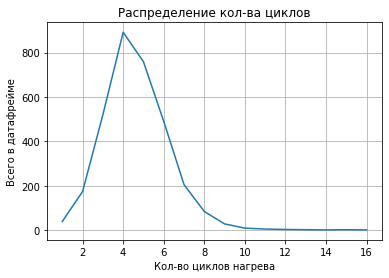

In [7]:
df_arc.groupby(by='key').count() \
                        .groupby(by='Реактивная мощность').count()['Активная мощность'] \
                        .plot(title='Распределение кол-ва циклов', 
                              xlabel='Кол-во циклов нагрева',
                              ylabel='Всего в датафрейме').grid(True)

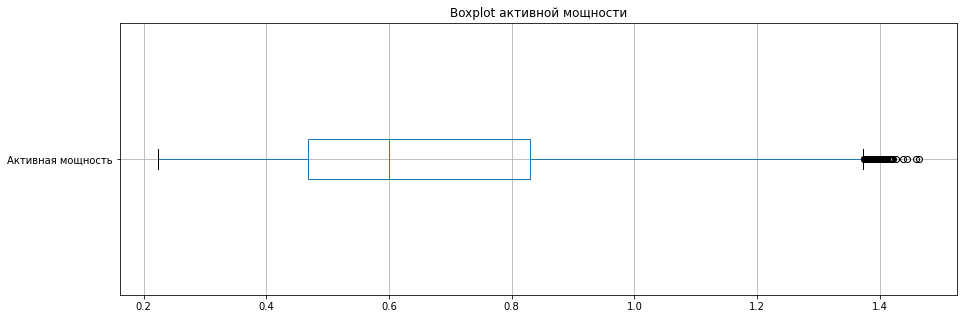

In [8]:
df_arc.boxplot(column='Активная мощность', figsize=(15,5), vert=False).set_title('Boxplot активной мощности');

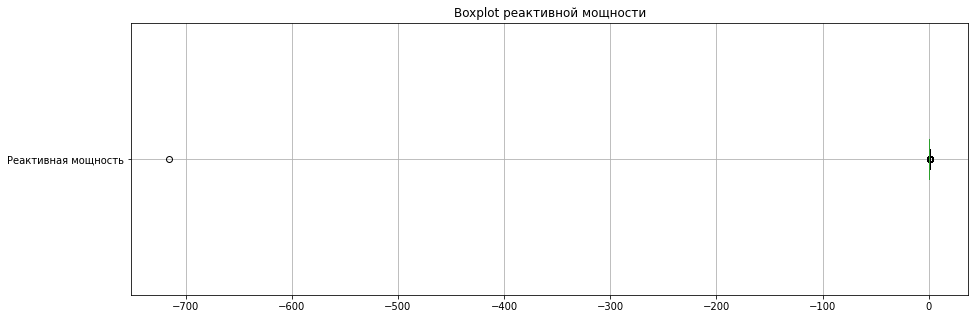

In [9]:
df_arc.boxplot(column='Реактивная мощность', figsize=(15,5), vert=False).set_title('Boxplot реактивной мощности');

### Данные о подаче сыпучих материалов (объём)

In [10]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
round(df_bulk.isna().sum()/len(df_bulk)*100,2)

key         0.00
Bulk 1     91.95
Bulk 2     99.30
Bulk 3     58.52
Bulk 4     67.59
Bulk 5     97.54
Bulk 6     81.59
Bulk 7     99.20
Bulk 8     99.97
Bulk 9     99.39
Bulk 10    94.38
Bulk 11    94.34
Bulk 12    21.70
Bulk 13    99.42
Bulk 14    10.32
Bulk 15    28.16
dtype: float64

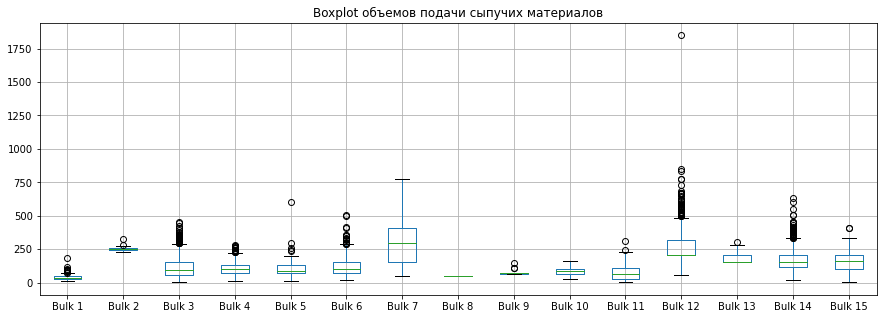

In [13]:
df_bulk.drop('key', axis=1).boxplot(figsize=(15,5)).set_title('Boxplot объемов подачи сыпучих материалов');

### Данные о подаче сыпучих материалов (время)

In [14]:
df_bulk_t.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [15]:
df_bulk_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [16]:
round(df_bulk_t.isna().sum()/len(df_bulk_t)*100,2)

key         0.00
Bulk 1     91.95
Bulk 2     99.30
Bulk 3     58.52
Bulk 4     67.59
Bulk 5     97.54
Bulk 6     81.59
Bulk 7     99.20
Bulk 8     99.97
Bulk 9     99.39
Bulk 10    94.38
Bulk 11    94.34
Bulk 12    21.70
Bulk 13    99.42
Bulk 14    10.32
Bulk 15    28.16
dtype: float64

### Данные о продувке сплава газом

In [17]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


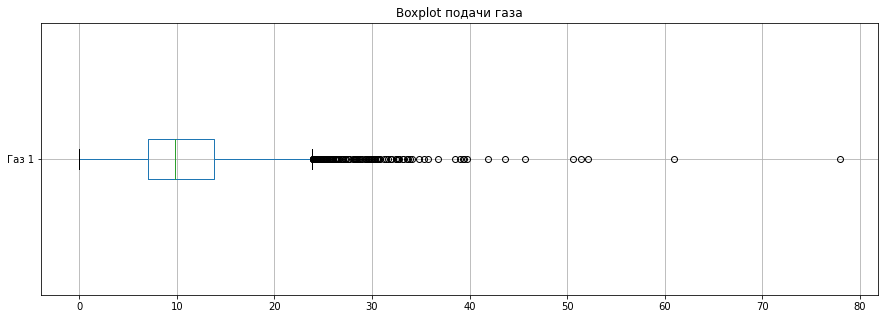

In [19]:
df_gas.drop('key', axis=1).boxplot(figsize=(15,5), vert=False).set_title('Boxplot подачи газа');

### Результаты измерения температуры

In [20]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [21]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [22]:
df_temp.groupby(by='key').count()['Температура'].unique()

array([ 6,  5,  7,  4,  8, 13, 11, 14,  2,  3,  9,  1, 10, 12, 16, 17])

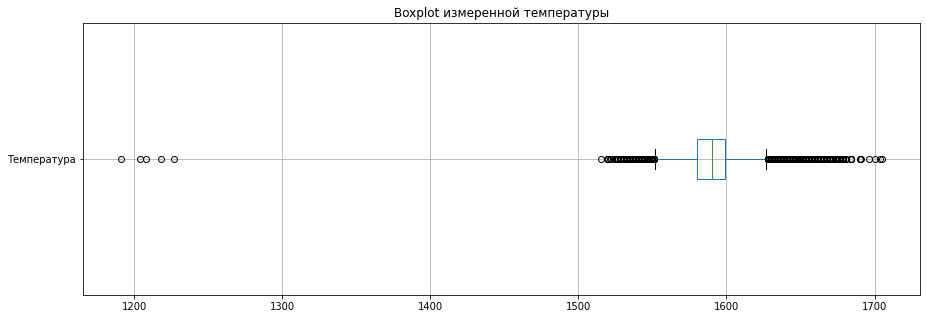

In [23]:
df_temp.boxplot(column='Температура', figsize=(15,5), vert=False).set_title('Boxplot измеренной температуры');

### Данные о проволочных материалах (объём)

In [24]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [26]:
round(df_wire.isna().sum()/len(df_wire)*100,2)

key        0.00
Wire 1     0.84
Wire 2    64.98
Wire 3    97.96
Wire 4    99.55
Wire 5    99.97
Wire 6    97.63
Wire 7    99.64
Wire 8    99.38
Wire 9    99.06
dtype: float64

### Данные о проволочных материалах (время)

In [27]:
df_wire_t.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_wire_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Вывод

Таким образом, мы имеем следующее:
1. В данных об электродах имеются аномальные значения реактивной мощности, которые необходимо будет удалить, а также агрегировать начало и конец нагрева в общее время нагрева. В данных преимущественно присутствуют процессы с количеством итераций от 2 до 7, что возможно будет полезно для модели в качестве нового признака.

2. В данных об объеме и времени подачи сыпучих и проволочных материалов много пропусков, необходимо убрать материалы, пропуски в применении которых превышает 80% (преимущественно >90), а так же заполнить нулями пропуски в оставшихся данных.

3. В данных о продувке пропусков нет, присутствуют аномалии.

4. В результатах измерения температуры присутствуют аномалии и пропуски в значениях измерения. Так как температура не может быть меньше 1500, а так же необходимы значения температур в начале и конце процесса - неподходящие ключи необходимо удалить.

## План работы

Для успешного выполнения данного проекта необходимо:
1. в соответсвии с выводами по исследовательскому анализу данных провести предобработку данных;
2. сгенерировать новые признаки, оценить корреляцию признаков;
2. объединить данные в один датасет, с удалением признаков, не имеющих значения для модели, а так же удаление столбца key; 
3. разбиение данных на обучающую и тестовую выборки;
4. анализ нескольких моделей с подбором гиперпараметров;
5. выбор лучшей модели и ее проверка на тестовой выборке;
6. написание отчета.

## Предобработка данных

### Данные об электродах

Избавимся от аномалий

In [29]:
df_arc = df_arc.loc[(df_arc['Реактивная мощность']>0)]

Преобразуем времена начала и окончания итераций в один признак времени нагрева

In [30]:
df_arc['Время нагрева'] = (pd.to_datetime(df_arc['Конец нагрева дугой'])-\
                                         pd.to_datetime(df_arc['Начало нагрева дугой'])).dt.total_seconds()
df_arc = df_arc.drop(['Начало нагрева дугой','Конец нагрева дугой'], axis=1)
df_arc = df_arc.groupby(by='key').agg({'key':'count',
                                       'Время нагрева':'sum',
                                       'Реактивная мощность':'sum',
                                       'Активная мощность':'sum'})
df_arc.head()

,key,Время нагрева,Реактивная мощность,Активная мощность
key,,,,
1,5,1098.0,2.142821,3.036730
2,4,811.0,1.453357,2.139408
3,5,655.0,2.937457,4.063641
4,4,741.0,2.056992,2.706489
5,4,869.0,1.687991,2.252950


In [31]:
df_arc.columns = ['Кол-во нагревов','Время нагрева','Реактивная мощность','Активная мощность']
df_arc = df_arc.reset_index()

In [32]:
df_arc.head()

,key,Кол-во нагревов,Время нагрева,Реактивная мощность,Активная мощность
0,1,5,1098.0,2.142821,3.036730
1,2,4,811.0,1.453357,2.139408
2,3,5,655.0,2.937457,4.063641
3,4,4,741.0,2.056992,2.706489
4,5,4,869.0,1.687991,2.252950


### Данные о подаче материалов

Уберем материалы, чье использование и, следовательно, влияние мало

In [33]:
useful_bulk = df_bulk.isna().sum()/len(df_bulk)<0.8
useful_bulk

key         True
Bulk 1     False
Bulk 2     False
Bulk 3      True
Bulk 4      True
Bulk 5     False
Bulk 6     False
Bulk 7     False
Bulk 8     False
Bulk 9     False
Bulk 10    False
Bulk 11    False
Bulk 12     True
Bulk 13    False
Bulk 14     True
Bulk 15     True
dtype: bool

In [34]:
df_bulk = df_bulk.loc[:,useful_bulk]
df_bulk_t = df_bulk_t.loc[:,useful_bulk]

In [35]:
useful_wire = df_wire.isna().sum()/len(df_wire)<0.8
useful_wire

key        True
Wire 1     True
Wire 2     True
Wire 3    False
Wire 4    False
Wire 5    False
Wire 6    False
Wire 7    False
Wire 8    False
Wire 9    False
dtype: bool

In [36]:
df_wire = df_wire.loc[:,useful_wire]
df_wire_t = df_wire_t.loc[:,useful_wire];

Оставшиеся пропуски заполним нулями.

In [37]:
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0);

### Результаты измерения температуры

Уберем аномальные значения температуры и записи с одним измерением температуры.

In [38]:
df_temp = df_temp.query('Температура > 1500')
df_temp = df_temp[df_temp.duplicated(subset='key', keep=False)]

Добавим признак времени между первым и последним замером температуры партии.

In [39]:
df_temp_fl = df_temp.groupby(by='key').agg({'first','last'}).reset_index()
df_temp_fl['dt_mer_temp'] = (pd.to_datetime(df_temp_fl['Время замера']['last']) - \
                                           pd.to_datetime(df_temp_fl['Время замера']['first'])).dt.total_seconds()
df_temp_fl = df_temp_fl.drop('Время замера', axis=1)
df_temp_fl.columns = ['key','first','last','dt_mer_temp']
df_temp = df_temp_fl
df_temp.head(10)

,key,first,last,dt_mer_temp
0,1,1613.0,1571.0,1714.0
1,2,1602.0,1581.0,1265.0
2,3,1599.0,1596.0,1753.0
3,4,1625.0,1601.0,1220.0
4,5,1602.0,1576.0,1536.0
5,6,1596.0,1543.0,1497.0
6,7,1599.0,1586.0,1744.0
7,8,1598.0,1577.0,1615.0
8,9,1592.0,1587.0,1811.0
9,10,1593.0,1574.0,1551.0


## Объединение данных

Объединим таблицы по значению партии, сохраняя лишь те партии, которые есть во всех таблицах.

In [40]:
df = df_arc.merge(df_bulk, on='key', how='inner')
df = df.merge(df_wire, on='key', how='inner')
df = df.merge(df_temp, on='key', how='inner')
df = df.merge(df_gas, on='key', how='inner')

In [41]:
df.tail()

,key,Кол-во нагревов,Время нагрева,Реактивная мощность,Активная мощность,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,first,last,dt_mer_temp,Газ 1
2324,2495,4,723.0,2.210936,3.168133,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000,1591.0,1570.0,1380.0,7.125735
2325,2496,6,940.0,2.872031,4.174918,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000,1591.0,1554.0,1705.0,9.412616
2326,2497,3,569.0,2.452092,3.605239,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800,1589.0,1571.0,962.0,6.271699
2327,2498,5,750.0,2.239820,3.202310,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000,1594.0,1591.0,1520.0,14.953657
2328,2499,4,883.0,1.296836,1.737084,47.0,0.0,233.0,126.0,227.0,110.160958,50.00528,1603.0,1569.0,1537.0,11.336151


Удалим признак партии.

In [42]:
df = df.drop('key', axis=1)

In [43]:
df

,Кол-во нагревов,Время нагрева,Реактивная мощность,Активная мощность,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,first,last,dt_mer_temp,Газ 1
0,5,1098.0,2.142821,3.036730,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000,1613.0,1571.0,1714.0,29.749986
1,4,811.0,1.453357,2.139408,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000,1602.0,1581.0,1265.0,12.555561
2,5,655.0,2.937457,4.063641,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000,1599.0,1596.0,1753.0,28.554793
3,4,741.0,2.056992,2.706489,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000,1625.0,1601.0,1220.0,18.841219
4,4,869.0,1.687991,2.252950,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456,1602.0,1576.0,1536.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,4,723.0,2.210936,3.168133,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000,1591.0,1570.0,1380.0,7.125735
2325,6,940.0,2.872031,4.174918,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000,1591.0,1554.0,1705.0,9.412616
2326,3,569.0,2.452092,3.605239,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800,1589.0,1571.0,962.0,6.271699
2327,5,750.0,2.239820,3.202310,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000,1594.0,1591.0,1520.0,14.953657


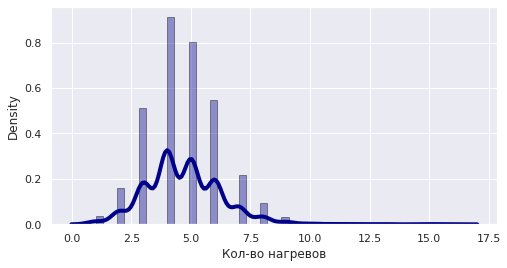

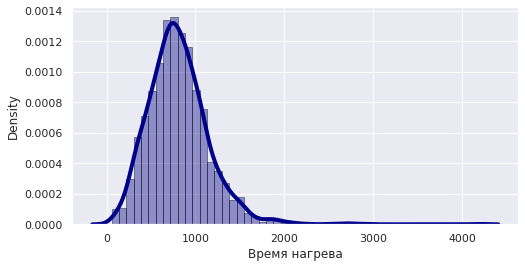

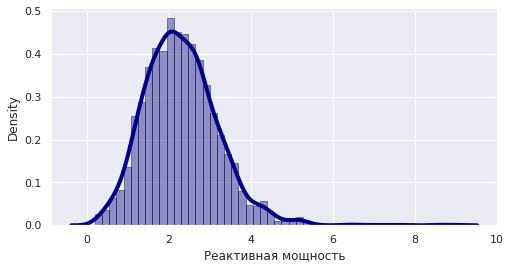

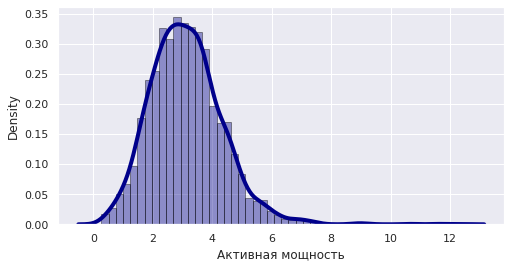

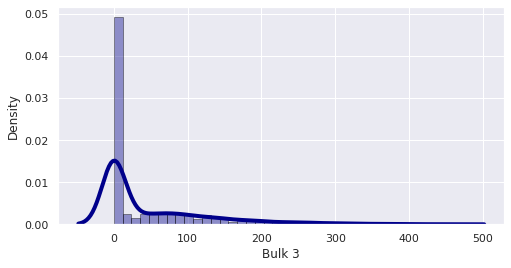

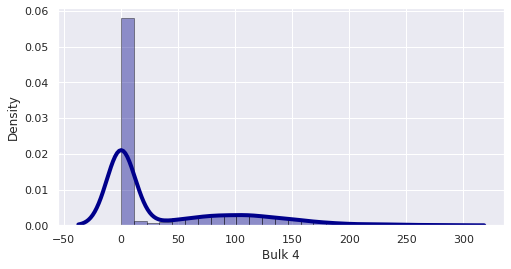

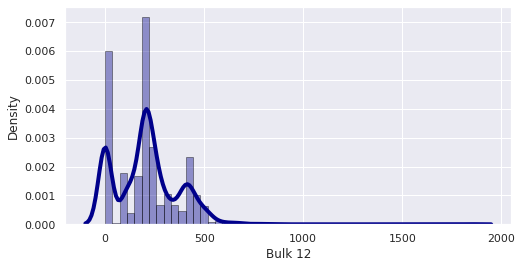

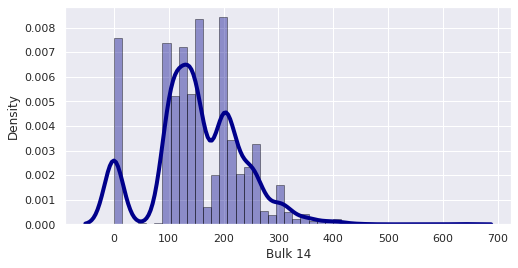

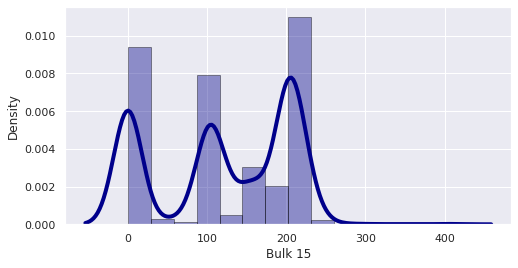

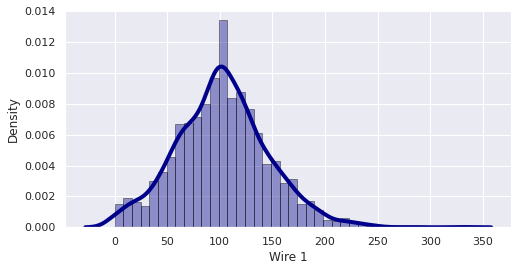

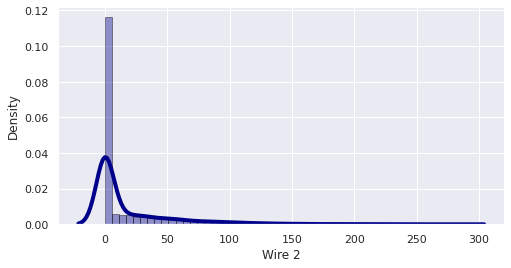

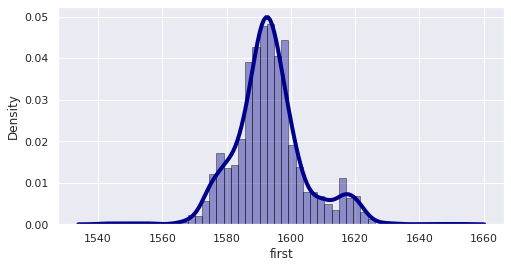

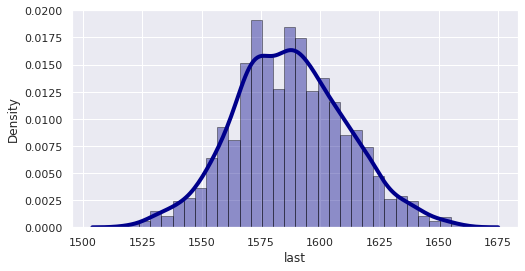

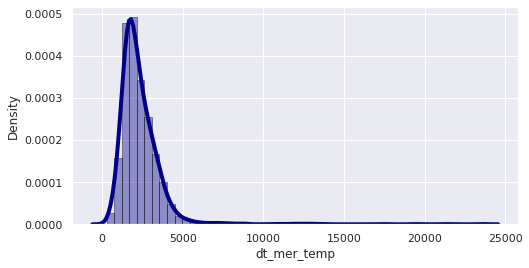

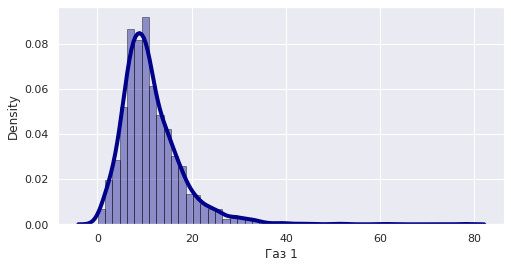

In [44]:
sns.set(rc={"figure.figsize":(8, 4)})
for i in df:
    sns.distplot(df[i], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    plt.show()

## Корреляция данных

Определим корреляцию признаков.

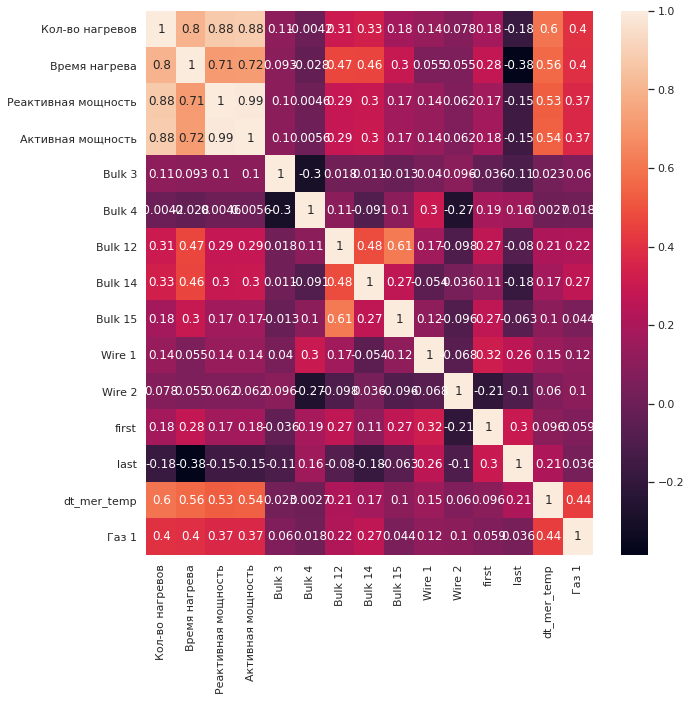

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, ax=ax);

Мощности имеют высокую корреляцию, объединим их в один признак полной мощности.

In [46]:
df['Полная мощность'] = df['Реактивная мощность'] + df['Активная мощность']
df = df.drop(['Реактивная мощность','Активная мощность'], axis=1)

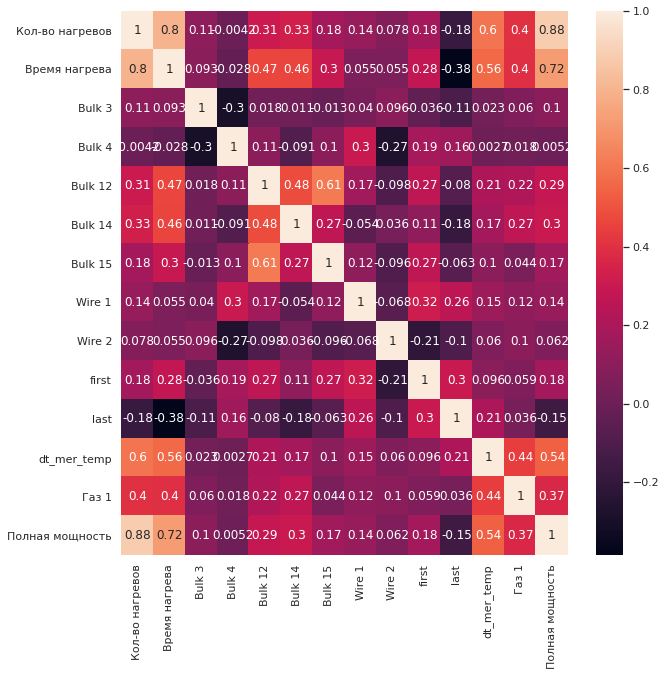

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, ax=ax);

## Обучение моделей

Разделим датасет на обучающую и тестовую выборку в соотношении 3:1. Обучим модели CatBoostRegressor, LGBMRegressor и RandomForestRegressor.

In [48]:
target = df['last']
features = df.drop('last', axis=1)
random_state = 170723
np.random.seed(random_state)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=random_state, shuffle=False)
features_train, target_train = shuffle(features_train, target_train, random_state=random_state)
features_test, target_test = shuffle(features_train, target_train, random_state=random_state)

In [49]:
print(features_train.shape)
print(features_test.shape)

(1746, 13)
(1746, 13)


In [51]:
np.random.seed(random_state)
model_cat = CatBoostRegressor(random_state=random_state, eval_metric='MAE')
parameters = {'iterations' : sp_randInt(10, 200),
              'depth' : sp_randInt(2, 10),
             }
randm_src = model_cat.randomized_search(param_distributions=parameters, X=features_train, 
                                        y=target_train, verbose=False);

0:	learn: 1542.5095391	test: 1542.2711847	best: 1542.2711847 (0)	total: 53ms	remaining: 4.5s
1:	learn: 1498.7478042	test: 1498.3858067	best: 1498.3858067 (1)	total: 70.4ms	remaining: 2.96s
2:	learn: 1455.5347450	test: 1455.0811890	best: 1455.0811890 (2)	total: 74.8ms	remaining: 2.07s
3:	learn: 1414.1168908	test: 1413.6223202	best: 1413.6223202 (3)	total: 78.9ms	remaining: 1.62s
4:	learn: 1374.3069704	test: 1373.5741516	best: 1373.5741516 (4)	total: 82.8ms	remaining: 1.34s
5:	learn: 1336.0898895	test: 1335.2411979	best: 1335.2411979 (5)	total: 86.7ms	remaining: 1.16s
6:	learn: 1298.5519936	test: 1298.1002088	best: 1298.1002088 (6)	total: 90.6ms	remaining: 1.02s
7:	learn: 1261.4515328	test: 1260.8327284	best: 1260.8327284 (7)	total: 95ms	remaining: 927ms
8:	learn: 1227.2071709	test: 1226.8324268	best: 1226.8324268 (8)	total: 99.1ms	remaining: 848ms
9:	learn: 1193.8266584	test: 1194.4376292	best: 1194.4376292 (9)	total: 103ms	remaining: 782ms
10:	learn: 1159.5712572	test: 1160.3195835	bes

In [52]:
print("Лучшая модель CatBoost:\n", randm_src['params'])
print("Лучшая MAE:\n", randm_src['cv_results']['train-MAE-mean'][int(randm_src['params']['iterations'])-1])

Лучшая модель CatBoost:
 {'depth': 4.0, 'iterations': 191.0}
Лучшая MAE:
 15.735833363196264


In [53]:
np.random.seed(random_state)
model_LGBMR = LGBMRegressor(random_state=random_state)
parameters = {'num_iterations' : sp_randInt(10, 200),
              'max_depth'    : sp_randInt(2, 10)
             }
randm_src_LGBMR = RandomizedSearchCV(estimator=model_LGBMR, param_distributions=parameters, 
                               n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=random_state)
randm_src_LGBMR.fit(features_train, target_train)
print("Лучшая модель:\n", randm_src_LGBMR.best_estimator_)
print("Лучшая MAE:\n", abs(randm_src_LGBMR.best_score_))

Лучшая модель:
 LGBMRegressor(max_depth=7, num_iterations=86, random_state=170723)
Лучшая MAE:
 9.937801392031165


In [54]:
np.random.seed(random_state)
model_forest = RandomForestRegressor(random_state=random_state)
parameters = {'n_estimators' : sp_randInt(10, 200),
              'max_depth'    : sp_randInt(2, 10)
             }
randm_src_forest = RandomizedSearchCV(estimator=model_forest, param_distributions=parameters, 
                                      n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=random_state)
randm_src_forest.fit(features_train, target_train)
print("Лучшая модель:\n", randm_src_forest.best_estimator_)
print("Лучшая MAE:\n", abs(randm_src_forest.best_score_))

Лучшая модель:
 RandomForestRegressor(max_depth=9, n_estimators=182, random_state=170723)
Лучшая MAE:
 10.260460691020047


Среди обученных моделей лучше себя показала LGBMRegressor, оценим ее качество на тестовой выборке.

## Проверка лучшей модели

In [55]:
best_model_LGBMR = randm_src_LGBMR.best_estimator_
best_model_LGBMR.fit(features_train, target_train)
predict_LGBMR = best_model_LGBMR.predict(features_test)
print('MAE test', mean_absolute_error(predict_LGBMR, target_test))
print("R2 =", r2_score(target_test, predict_LGBMR))

MAE test 5.8884551948675465
R2 = 0.8863722813199726


Достигнутое MAE модели удовлятворяет условию быть меньше 6.8.
По метрике R2 видим, что модель работает лучше чем среднее (> 0), предсказания не идеальны (< 1).

In [56]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predict_dum = dummy_regr.predict(features_test)
print('MAE test', mean_absolute_error(predict_dum, target_test))

MAE test 18.063768732065043


MAE константной модели выше обученной модели, модель адекватна. Оценим важность признаков с помощью библиотеки SHAP.

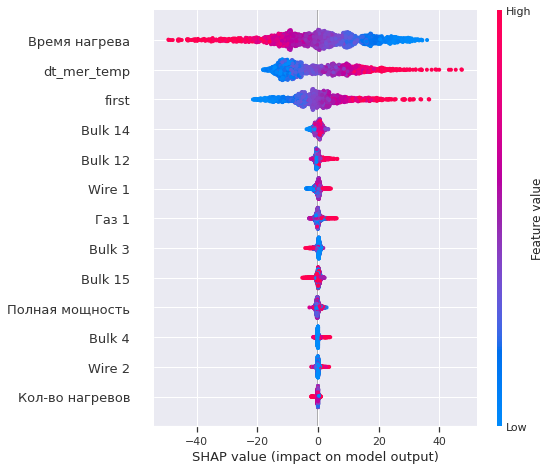

In [57]:
shap_test = shap.TreeExplainer(best_model_LGBMR).shap_values(features_test)
shap.summary_plot(shap_test, features_test,
                      max_display=25, auto_size_plot=True)

Можем сказать, что большее влияние оказывют следующие признаки:

1. Суммарное время нагрева партии - в сторону уменьшения целевого признака,
2. Время между первым и последним измерением температуры в партии - в сторону увеличения целевого признака,
3. Начальная температура - 	в сторону увеличения целевого признака.


## Итоговый вывод

В проекте был произведен исследователский анализ данных, с полученной информацией и в соответвии с рекомендациями заказчика определены проблемные моменты, которые были проработаны в предобработке данных, сгенерированы новые признаки: полное время нагрева, время между первым и последним измерением температуры в партии.

После объединения таблиц был получен датафрейм содержащий 15 признаков (2329 ключей). Оценив корреляцию признаков было определена высокая зависимость признаков мощности электродов - были объеденены в общий признак полной мощности.

Далее были обучены 3 модели на обучающей выборке (3:1 к тестовой выборке):
- CatBoostRegressor, 
- LGBMRegressor,
- RandomForestRegressor

Лучший результат был получен на LGBMRegressor - 5.88 MAE, 0.88 R2.
Модель адекватна, влиятельные признаки Суммарное время нагрева партии, Время между первым и последним измерением температуры, начальная температура.

## Отчет

### Сравнение решения и плана
В данном проекте были выполнены все этапы согласно Плану работы, а так же был проведен расчет метрики R2 для лучшей модели и оценена важность признаков.

### Описание трудностей проекта и как они были решены
В целом особо трудных моментов не было. Могу лишь обратить внимание на генерацию новых признаков по представленным данным - было интересно подумать, а так же иногда было сложно находить информацию, с которой когда-то сталкивался и работал, но забыл когда и где, на будущее необходимо лучше собрать и классифицировать информацию которой владеешь, для меньшей траты времени на ее поиск.

### Описание ключевых шагов решения
Основные ключевые шаги:
1. Загрузка данных и библиотек.
2. Исследование данных для ознакомления с ней, определения аномалий, пропусков и других проблем в данных, которые будет необходимо решить.
3. Определение этапов решения поставленной задачи.
4. Предобработка данных - решение проблем данных, выявленных при их исследовании. Генерация новых полезных признаков и удаление малоинформативных для модели.
5. Объединение таблиц в один датафрейм, с последующим выделением обучающей и тестовых выборой, целевого признака.
6. Обучение моделей с подбором гиперпараметров, определение лучшей модели по метрике MAE.
7. Проверка лучшей модели на тестовой выборке, сверка полученного результата с требуемым значением, при недостаточном качестве полученной модели, продолжение работы с признаками.

### Все признаки, которые использовались для обучения Итоговой модели и описать конкретно, как все эти признаки предобрабатывались 
Признаки, использовавшиеся для обучения модели:
- Кол-во нагревов - сгенерированный признак - посчитанное кол-во нагревов в одной партии.	
- Время нагрева	- сгенерированный признак - временная разница между концом и началом нагрева (сумма, если нагревов несколько).
- Полная мощность - сгенерированный признак - сумма реактивной и активной мощности. Из реактивной мощности удалены значения < 0.
- Bulk 3 - ↓ 	
- Bulk 4 - ↓	
- Bulk 12 - ↓	
- Bulk 14 - ↓ 	
- Bulk 15 - ↓  	
- Wire 1 - ↓	 
- Wire 2 - подача сыпучего (Bulk) и проволочного (Wire) материала, удалены материалы, пропуски в которых составляют более 80%. Оставшиеся пропуски заполнены 0.
- first - температура металла перед обработкой.
- dt_mer_temp - сгенерированный признак - время между первым и последним измерением температуры в обработке партии.
- Газ 1 - не предобрабатывался.

### Полное описание Итоговой модели
Лучшая модель: 
- LGBMRegressor(max_depth=7, num_iterations=86, random_state=170723)

Результаты на тесте:
- MAE = 5.88
- R2 = 0.88